In [1]:
import sys
sys.path.append(r'C:\PythonVenv\PaintByNumber\Lib\site-packages')
import cv2, numpy as np, matplotlib.pyplot as plt

In [2]:
def load_image(_i_path):
    return cv2.imread(_i_path)

def natural_color(_i):
    return cv2.cvtColor(_i, cv2.COLOR_BGR2RGB)

def lab_color(_i):
    return cv2.cvtColor(_i, cv2.COLOR_BGR2LAB)

def bgr_color(_i): # from rgb
    return cv2.cvtColor(_i, cv2.COLOR_RGB2BGR)

def display_image(_i):
    plt.imshow(_i)
    plt.colorbar()
    plt.show()
    
def save_image(_i, _i_path):
    cv2.imwrite(_i_path, _i)
    
def unique_colors(_im, return_counts=False):
    return np.unique(
        _im.reshape(-1, _im.shape[2]),
        axis=0,
        return_counts=return_counts
    )

def segment_kmeans(_im, k=30):
    pixel_values = _im.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .3)
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]
    return segmented_image.reshape(_im.shape)

def blur(_im, radius=5):
    return cv2.blur(_im, (radius, radius))

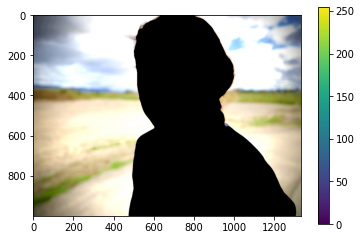

50156 unique colors


In [4]:
back = load_image("background.png")
display_image(natural_color(back))
print("{} unique colors".format(len(unique_colors(back))))

In [5]:
back_blur = blur(back)
back_blur_seg10 = segment_kmeans(back_blur)

NameError: name 'back_blur_seg30' is not defined

30 unique colors


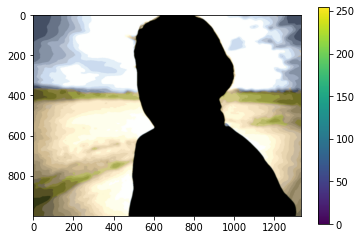

In [7]:
print("{} unique colors".format(len(unique_colors(back_blur_seg10))))
save_image(back_blur_seg10, "back_blur_seg10.png")
seg_rgb = natural_color(back_blur_seg10)
display_image(seg_rgb)

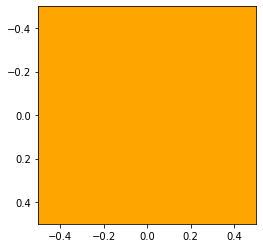

In [8]:
def print_color(color_rgb):
    import matplotlib.pyplot as plt
    plt.imshow([[color_rgb]])

def our_rgb_paints():
    import matplotlib
    emily_colors = {
        1: "mediumorchid",
        2: "black",
        3: "orange",
        4: "deepskyblue",
        5: "palegreen",
        6: "navy",
        7: "mintcream",
        8: "azure",
        9: "seagreen",
        10: "salmon",
        11: "mistyrose",
        12: "mediumaquamarine",
        13: "yellow",
        14: "darkkhaki",
        15: "snow",
        16: "peru",
        17: "gold",
        18: "bisque",
        19: "red",
        20: "orchid",
        21: "blueviolet",
        22: "mediumpurple",
        23: "thistle",
        24: "pink",
    }
    return {
        k: [255 * _c for _c in matplotlib.colors.to_rgb(v)]
        for k, v in emily_colors.items()
    }

our_rgb = our_rgb_paints()
# verify that code 3 is orange
print_color([_c/255 for _c in our_rgb[3]])

In [9]:
actual_rgb = unique_colors(seg_rgb)

In [10]:
from math import sqrt
import matplotlib
import pprint

def color_trio_to_array(trio):
    return np.array([[trio]])

def rgb_to_hsv(rgb):
    rgb_array = color_trio_to_array(rgb).astype(np.uint8)
    return cv2.cvtColor(rgb_array, cv2.COLOR_RGB2HSV)[0][0]

def closest_color_hsv(rgb, color_set):
    hsv = rgb_to_hsv(rgb)
    h, s, v = hsv
    color_diffs = []
    for rgb_ in color_set:
        hsv_ = rgb_to_hsv(rgb_)
        h_, s_, v_ = hsv_
        color_diff = sqrt(10*(h - h_)**2 + .1*(s - s_)**2 + .1*(v - v_)**2)
        color_diffs.append((color_diff, rgb_))
    return min(color_diffs)[1], min(color_diffs)[0]

def closest_color_rgb(rgb, color_set):
    #https://en.wikipedia.org/wiki/Color_difference#sRGB #fascinating stuff
    r, g, b = rgb
    color_diffs = []
    for rgb_ in color_set:
        r_, g_, b_ = rgb_
        color_diff = sqrt(.3*(r - r_)**2 + .59*(g - g_)**2 + .11*(b - b_)**2)
        color_diffs.append((color_diff, rgb_))
    return min(color_diffs)[1], min(color_diffs)[0]

In [11]:
def replace_color(array, initial, final):
    r1, g1, b1 = initial
    r2, g2, b2 = final
    red, green, blue = array[:,:,0], array[:,:,1], array[:,:,2]
    mask = (red == r1) & (green == g1) & (blue == b1)
    array[:,:,:3][mask] = [r2, g2, b2]

Changed 16 colors, 14 left unchanged


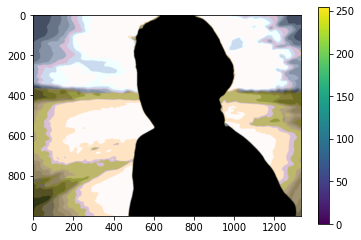

In [29]:
orig_colors = {}
above_thresh = 0
below_thresh = 0
thresh = 19
for orig_rgb in actual_rgb:
    closest, distance = closest_color_rgb(orig_rgb, our_rgb.values())
    orig_colors[tuple(orig_rgb)] = [[int(_c) for _c in closest], distance]
    if distance > thresh: above_thresh+=1
    else: below_thresh+=1
print("Changed {} colors, {} left unchanged".format(below_thresh, above_thresh))

seg_to_mod = natural_color(load_image("back_blur_seg10.png"))
for color, value in orig_colors.items():
    replace_with, distance = value
    if distance < thresh:
        replace_color(seg_to_mod, color, replace_with)
display_image(seg_to_mod)
save_image(bgr_color(seg_to_mod), "background_seg_to_mod_thresh{}.png".format(thresh))

In [21]:
def combine(foreground, background):
    return np.maximum(foreground, background)

In [31]:
final_product = combine(load_image("foreground_seg_to_mod_thresh23.png"), load_image("background_seg_to_mod_thresh19.png"))
save_image(final_product, "final_product_v3.png")